In [151]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist

# density estimation
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

import emcee
#import pymc3
import corner

#import dynesty

import sklearn
from sklearn import manifold
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import MeanShift
from sklearn.preprocessing import LabelEncoder

# Dimensional reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA

# Regression
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson

# Cross-Validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

# Classification
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from astroML.utils import split_samples, completeness_contamination
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

## The HR diagram

This assignment is about stars...

We will work with a star catalogue of 240 stars described by the following information:

- Temperature (in Kelvin)
- Luminosity (L/Lo)
- Radius (R/Ro)
- Absolute magnitude (Mv)

We also have the following data for each star:

- Color (Red/Orange/Yellow/White/Blue)
- Spectral class ('A', 'B', 'F', 'G', 'K', 'M', 'O')
- Star type (Brown dwarf/Red dwarf/White dwarf/Main sequence/Supergiant/Hypergiant)

This dataset has been collected by Deepraj Baidya and was originally published on Kaggle.

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")

('stars.csv', <http.client.HTTPMessage at 0x13b1cf80dc0>)

In [4]:
df_stars = pd.read_csv("stars.csv")
df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,Brown Dwarf,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Hypergiant,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Hypergiant,Blue,O
237,8829,537493.000000,1423.0000,-10.73,Hypergiant,White,A
238,9235,404940.000000,1112.0000,-11.23,Hypergiant,White,A


There are 6 star types that are encoded in the 'Star type' column. These labels are currently encoded as strings which is practical for reading but not for computing. Using scikit-learn, we will convert this column into integers by assigning a unique int value to each star type.

In [5]:
le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])
labels = le.inverse_transform(df_stars['Star type'])
class_names = le.classes_
print(class_names)

['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']


In [6]:
le_color = LabelEncoder()
df_stars['Star color'] = le_color.fit_transform(df_stars['Star color'])
labels_color = le_color.inverse_transform(df_stars['Star color'])
class_names_color = le_color.classes_
print(class_names_color)

['Blue' 'Blue ' 'Blue White' 'Blue white' 'Blue white ' 'Blue-White'
 'Blue-white' 'Orange' 'Orange-Red' 'Pale yellow orange' 'Red' 'White'
 'White-Yellow' 'Whitish' 'Yellowish' 'Yellowish White' 'white'
 'yellow-white' 'yellowish']


In [7]:
le_spectra = LabelEncoder()
df_stars['Spectral Class'] = le_spectra.fit_transform(df_stars['Spectral Class'])
labels_spectra = le_spectra.inverse_transform(df_stars['Spectral Class'])
class_names_spectra = le_spectra.classes_
print(class_names_spectra)

['A' 'B' 'F' 'G' 'K' 'M' 'O']


In [8]:
df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,10,5
1,3042,0.000500,0.1542,16.60,0,10,5
2,2600,0.000300,0.1020,18.70,0,10,5
3,2800,0.000200,0.1600,16.65,0,10,5
4,1939,0.000138,0.1030,20.06,0,10,5
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,1,0,6
236,30839,834042.000000,1194.0000,-10.63,1,0,6
237,8829,537493.000000,1423.0000,-10.73,1,11,0
238,9235,404940.000000,1112.0000,-11.23,1,11,0


We've seen this already last time. It is often grood practice to start with a statistical analysis of the dataset to answer the following questions:

- are there any missing values?
- are there NaNs in the data?

Star classification is something that can be done based on rules depending on temperature and luminosity. For example, Wikipedia gives the following example of a Hertzsprung-Russell diagram:

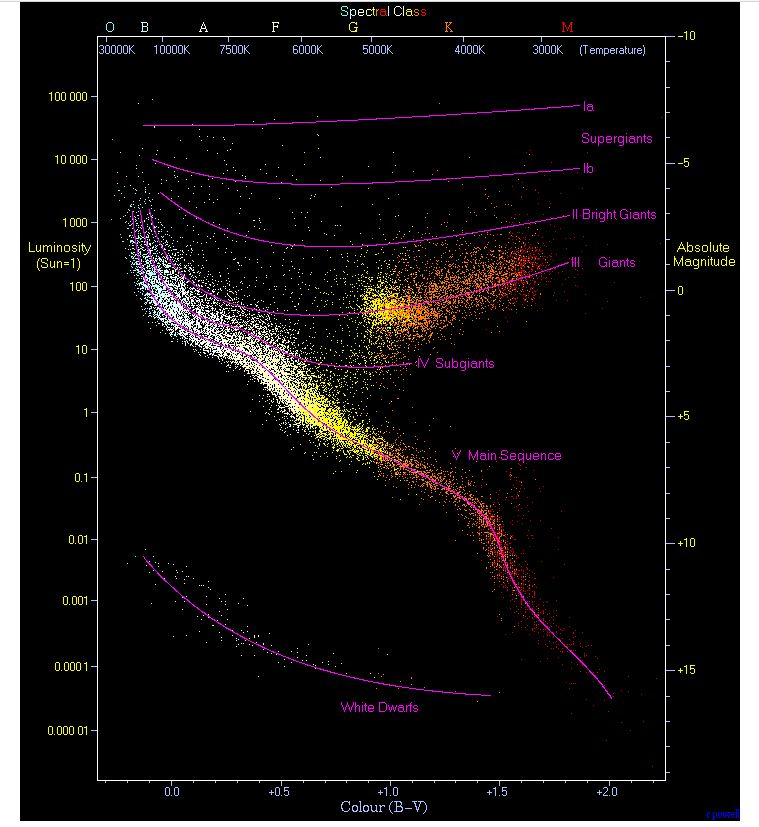

We can reproduce this diagram by plotting the scatter plot of our stars using the same variables in log-log-scale.

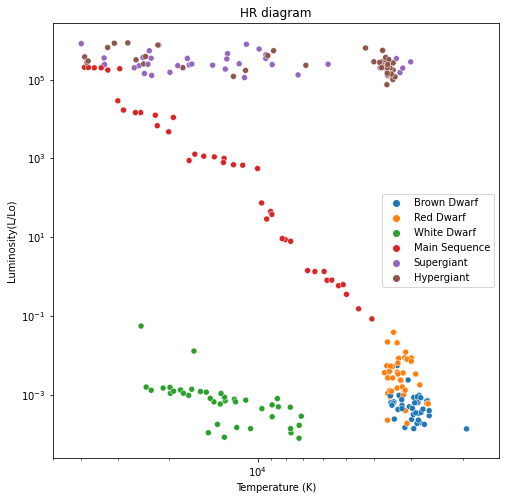

In [14]:
import seaborn as sns

fig = plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)

plt.xscale('log')
plt.yscale('log')
#plt.xticks([50000,20000,10000,9000,8000])
plt.xlim(5e4, 1.5e3)
plt.title('HR diagram')
plt.show()

We find the same organization of stars in this 2D plane. Main Sequence stars and White Dwarves are fairly easy to isolate from the rest: a statistical model should be able to easily classify them. Based only on Luminosity and Temperature, Dwarf stars and Giant stars have higher intra-group variability: Supergiant and Hypergiant cover the same space (same for Brown and Red Dwarves). Additionnal variables might be needed to correctly identify the types of those stars.

- Apply PCA to the dataset at your disposa (hint: don't use columns with labels, only those with real numbers).
- Project the dataset into the principal components, and do a scatter plot of the first two.
- This will look terrible. Think about the units!
- Explore what happens if you rescale the data first.

In [68]:
df_stars.shape

(240, 7)

In [69]:
X = np.array([df_stars['Temperature (K)'],df_stars['Luminosity(L/Lo)'],df_stars['Radius(R/Ro)'],df_stars['Absolute magnitude(Mv)']]).T
X.shape

(240, 4)

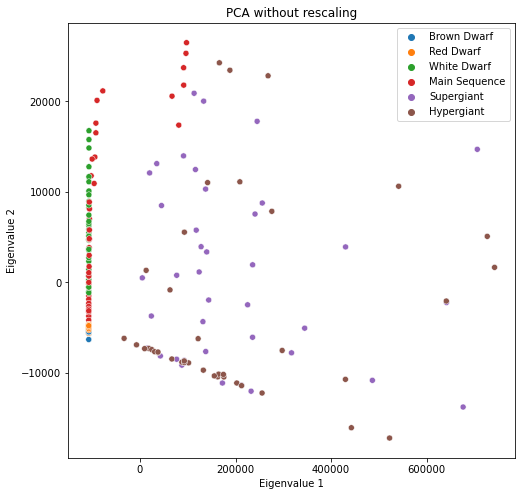

In [83]:
# apply PCA
pca = PCA()
pca.fit(X)
X_transformed = pca.transform(X)

fig = plt.figure(figsize=(8,8))

sns.scatterplot(x=X_transformed[:,0], y=X_transformed[:,1], hue=labels) 

#plt.xscale('log')
#plt.yscale('log')
plt.title('PCA without rescaling')
plt.xlabel('Eigenvalue 1')
plt.ylabel('Eigenvalue 2')
#plt.xlim(1e-6,1e6)
#plt.ylim(1e-5,1e5)

plt.legend()

This is actually a very important lesson in machine learning: Massaging your data before giving them to an algorithm can make things much much better.

- You can try an linear, affine transformation such that each dimension goes between -1 and 1.
- Or (which is the usual machine-learning approach) standardize your data such that each dimension has mean=0 and variance=1.
- Redo your PCA. Should be much much better.
- How much variance is explained by those two components?

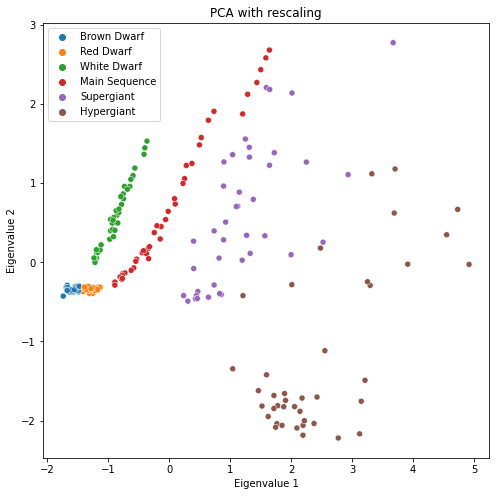

In [252]:
scaler = preprocessing.StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
X_scaled = scaler.fit_transform(X) # rescale the data

pca_scaled = PCA() # keep all the components

# PCA fit and projection
pca_scaled.fit(X_scaled)
X_transf_scaled = pca_scaled.transform(X_scaled)

fig = plt.figure(figsize=(8,8))

sns.scatterplot(x=X_transf_scaled[:,0], y=X_transf_scaled[:,1], hue=labels) 

plt.title('PCA with rescaling')
plt.xlabel('Eigenvalue 1')
plt.ylabel('Eigenvalue 2')

#plt.xscale('log')
#plt.yscale('log')

plt.legend()

In [95]:
evals = pca_scaled.explained_variance_ratio_
print('Explained variance ratio by 2 components:',np.sum(evals[:2]),'%')
print('Single components contribution:',evals,'%')

Explained variance ratio by 2 components: 0.8385817508043478 %
Single components contribution: [0.60357391 0.23500784 0.09329645 0.0681218 ] %


Text(0.5, 1.0, 'Variance embedded in the cumulative PCA components')

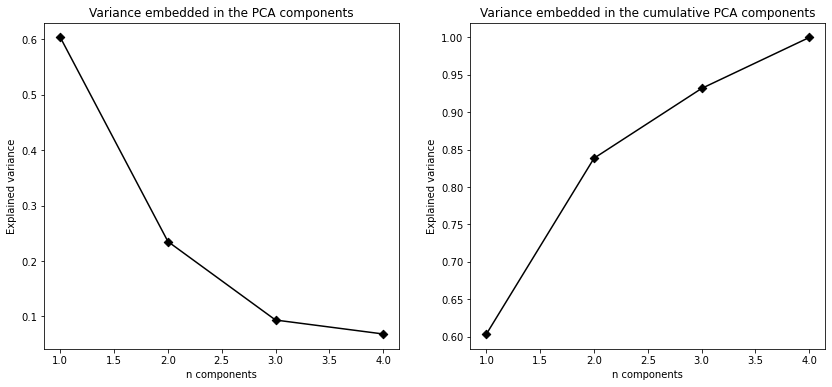

In [98]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(14,6))

ax[0].plot(np.arange(1,len(evals)+1),evals,color='black')
ax[0].scatter(np.arange(1,len(evals)+1),evals,color='black',marker='D')
ax[0].set_xlabel('n components')
ax[0].set_ylabel('Explained variance')
ax[0].set_title('Variance embedded in the PCA components')

ax[1].plot(np.arange(1,len(evals)+1),np.cumsum(evals),color='black')
ax[1].scatter(np.arange(1,len(evals)+1),np.cumsum(evals),color='black',marker='D')
ax[1].set_xlabel('n components')
ax[1].set_ylabel('Explained variance')
ax[1].set_title('Variance embedded in the cumulative PCA components')

## Classification algorithm 

Take only the first two eigenvectors determined by the PCA

### KNN

In [208]:
y = np.array(df_stars['Star type'])

# split the sample in train and test
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_transf_scaled[:,:2],y,test_size=0.25,train_size=0.75)

Let's try first with a generative classification method: KNN, since data seems to be non-linear or quadratic and the classification task is not binary (Bayesan)

In [209]:
# find the best number of components through cross-validation:
# perform Classification
scores_knc = []
kvals = np.arange(1,20)
for k in kvals:
    clf = KNeighborsClassifier(n_neighbors=k)
    CVpredk = cross_val_predict(clf, X_train, y_train)
    scores_knc.append(accuracy_score(y_train, CVpredk))

max score is for k = 1


Text(0.5, 1.0, 'Classification accuracy vs $k_{neighbors}$')

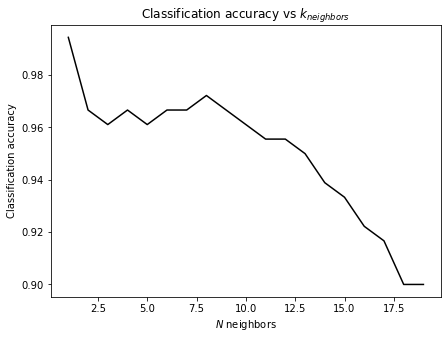

In [210]:
print("max score is for k =",kvals[np.argmax(scores_knc)])

# Plot number of neighbors vs score
fig = plt.figure(figsize=(7, 5))

plt.plot(kvals,scores_knc,color='black')
plt.xlabel('$N$ neighbors')
plt.ylabel('Classification accuracy')
plt.title(r'Classification accuracy vs $k_{neighbors}$')

In [236]:
# train and predict with the best KNN

best_k = kvals[np.argmax(scores_knc)]

knc_clf = KNeighborsClassifier(n_neighbors=best_k)
knc_clf.fit(X_train,y_train)
y_pred_knc = knc_clf.predict(X_test)
y_prob_knc = knc_clf.predict_proba(X_test)

In [237]:
confusion_matrix(y_test,y_pred_knc)

array([[ 8,  0,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0],
       [ 0,  0, 10,  0,  1,  0],
       [ 0,  0,  0, 14,  0,  0],
       [ 0,  4,  0,  0,  8,  0],
       [ 0,  0,  0,  0,  0,  5]], dtype=int64)

In [238]:
completeness_knc, contamination_knc = completeness_contamination(y_pred_knc, y_test)

print("completeness", completeness_knc)
print("contamination", contamination_knc)

completeness 0.9038461538461539
contamination 0.0


<AxesSubplot:>

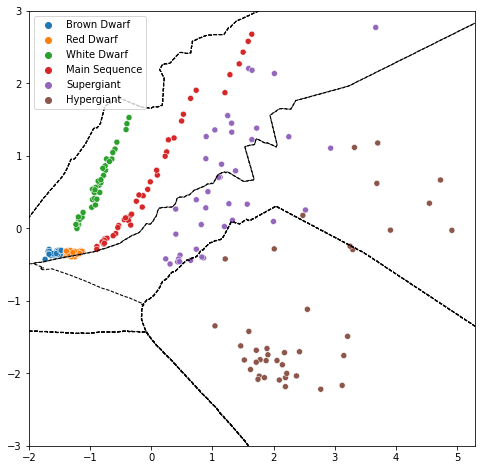

In [239]:
# plot the result of the classification
fig = plt.figure(figsize=(8,8))

# compute the decision boundaries:
xlim = (-2,5.3)
ylim = (-3,3)

xx,yy = np.meshgrid(np.linspace(xlim[0],xlim[1],1000),
                    np.linspace(ylim[0],ylim[1],1000))

Z = knc_clf.predict(np.c_[yy.ravel(),xx.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx,yy,Z,colors='k',linestyles='dashed',linewidths=1)

sns.scatterplot(x=X_transf_scaled[:,0], y=X_transf_scaled[:,1], hue=labels) 

Let's now try with a random forest regressor

### Random Forest

#### Cross-vallidation to determine the best hyperparameters

In [240]:
def error_func(y_true, y_m):
    N = len(y_true)
    return np.sqrt(1/N * np.sum((y_true-y_m)**2)) 

def cross_validation(X,y,model,split_method):
    "computes and returns the cross validation error and the training error, given the datasets and the model to validate"
    
    split = split_method # sample splitting
    
    err_train_i = []
    err_cv_i = []
    
    # iterating over the n_splits
    for train, test in split.split(X):
        
        # define the model given the splitted data
        model.fit(X[train],y[train]) 
        
        #define the variables to compute the errors
        y_train = model.predict(X[train])
        y_true_train = y[train]
        
        y_cv = model.predict(X[test])
        y_true_cv = y[test]
    
        # compute the errors on the training and cross-validation set for a given set
        err_train_i.append(error_func(y_true_train,y_train)) # compute the error on the training set
        err_cv_i.append(error_func(y_true_cv,y_cv)) # compute the error on the validation set
   
    err_train = np.mean(err_train_i)
    err_cv = np.mean(err_cv_i)
    
    return err_train, err_cv

9


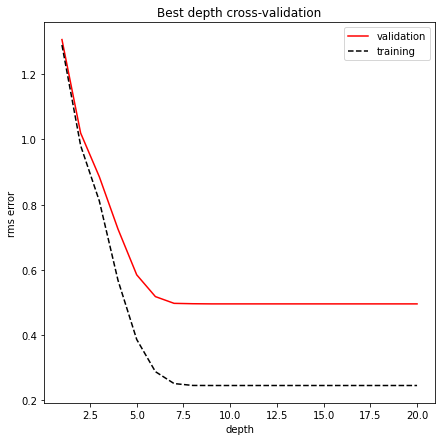

In [241]:
depth = np.arange(1, 21)

rms_val = np.zeros(len(depth))
rms_train = np.zeros(len(depth))

for d in depth:
    n_splits = 5
    split_method = KFold(n_splits)
    
    model = RandomForestRegressor(n_estimators=10,max_depth=d,random_state=0)
    
    rms_train[d-1],rms_val[d-1] = cross_validation(X_train,y_train,model,split_method)

best_depth = depth[np.argmin(rms_val)]
print(best_depth)

fig = plt.figure(figsize=(7,7))

plt.plot(depth,rms_val,label='validation',color='red')
plt.plot(depth,rms_train,label='training',color='black',ls='--')
plt.ylabel('rms error')
plt.xlabel('depth')
plt.title('Best depth cross-validation')
plt.legend()

In [242]:
clf_rf = RandomForestClassifier(n_estimators=20,max_depth=best_depth, random_state=0)
clf_rf.fit(X_train,y_train)

y_pred_rf = clf_rf.predict(X_test)

y_prob_rf = clf_rf.predict_proba(X_test)

##### Accuracy of the classification

In [243]:
completeness_rf, contamination_rf = completeness_contamination(y_pred_rf, y_test)

print("completeness", completeness_rf)
print("contamination", contamination_rf)

completeness 0.9230769230769231
contamination 0.0


In [244]:
confusion_matrix(y_test,y_pred_rf)

array([[ 8,  0,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0],
       [ 0,  0,  9,  0,  2,  0],
       [ 0,  0,  0, 14,  0,  0],
       [ 0,  2,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0,  5]], dtype=int64)

In [245]:
accuracy_rf = accuracy_score(y_test,y_pred_rf)

print('accuracy random forest:',accuracy_rf)

accuracy random forest: 0.9333333333333333


<AxesSubplot:>

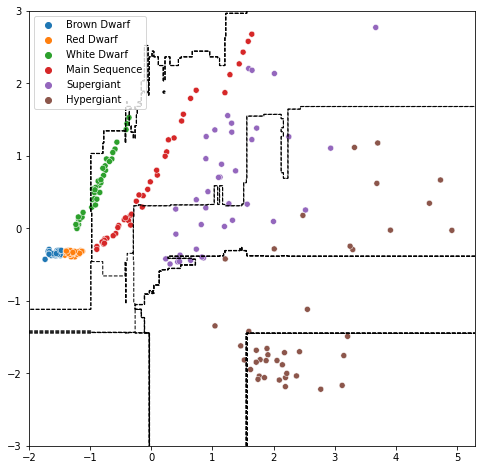

In [246]:
# plot the result of the classification
fig = plt.figure(figsize=(8,8))

# compute the decision boundaries:
xlim = (-2,5.3)
ylim = (-3,3)

xx,yy = np.meshgrid(np.linspace(xlim[0],xlim[1],1000),
                    np.linspace(ylim[0],ylim[1],1000))

Z = clf_rf.predict(np.c_[yy.ravel(),xx.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx,yy,Z,colors='k',linestyles='dashed',linewidths=1)

sns.scatterplot(x=X_transf_scaled[:,0], y=X_transf_scaled[:,1], hue=labels) 

### Compare the two methods:


In [247]:
confusion_matrix(y_pred_knc,y_pred_rf)

array([[ 8,  0,  0,  0,  0,  0],
       [ 0, 12,  0,  0,  2,  0],
       [ 0,  0,  8,  0,  2,  0],
       [ 0,  0,  0, 14,  0,  0],
       [ 0,  0,  1,  0,  8,  0],
       [ 0,  0,  0,  0,  0,  5]], dtype=int64)

In [248]:
completeness_comp, contamination_comp = completeness_contamination(y_pred_knc, y_test)

print("completeness", completeness_comp)
print("contamination", contamination_comp)

completeness 0.9038461538461539
contamination 0.0


# Stuff

### ROC curves

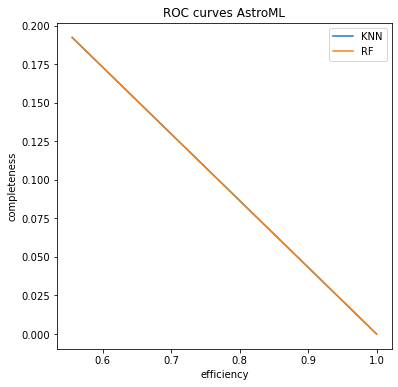

In [221]:
methods_clf = np.array(['KNN','RF'])
y_probs = np.array([y_prob_knc,y_prob_rf])

#plot
fig = plt.figure(figsize=(6,6))

for label, y_prob in zip(methods_clf,y_probs):
    
    #astroML
    thresholds = np.linspace(0, 1, 1001)[:-1] # grid of thresholds
    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        y_pred = (y_prob[:,-1] >= t)
        comp[i], cont[i] = completeness_contamination(y_pred, y_test)
        

    
    plt.plot(1-cont, comp,label=label)
    plt.title('ROC curves AstroML')
    plt.xlabel('efficiency')
    plt.ylabel('completeness')
    plt.legend()